In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, Ridge, SGDRegressor
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVR
import xgboost as XGB
import lightgbm as lgb
import scipy.stats as stats
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector, RFE, RFECV
from sklearn.inspection import permutation_importance

Importing training, testing datasets. 
Training set consists of 1.2 million samples and 20 features including Premium Amount
Test set consists of 800,000 samples

In [2]:
df = pd.read_csv('dataset/train.csv',index_col=0)
df_test = pd.read_csv('dataset/test.csv',index_col=0)
print('training data shape:',df.shape)
print('test data shape:',df_test.shape)

training data shape: (1200000, 20)
test data shape: (800000, 19)


## Plotting categorical features
The distribution of classes is quite even across features, with the exception of missing data. A lot of occupation data is missing.

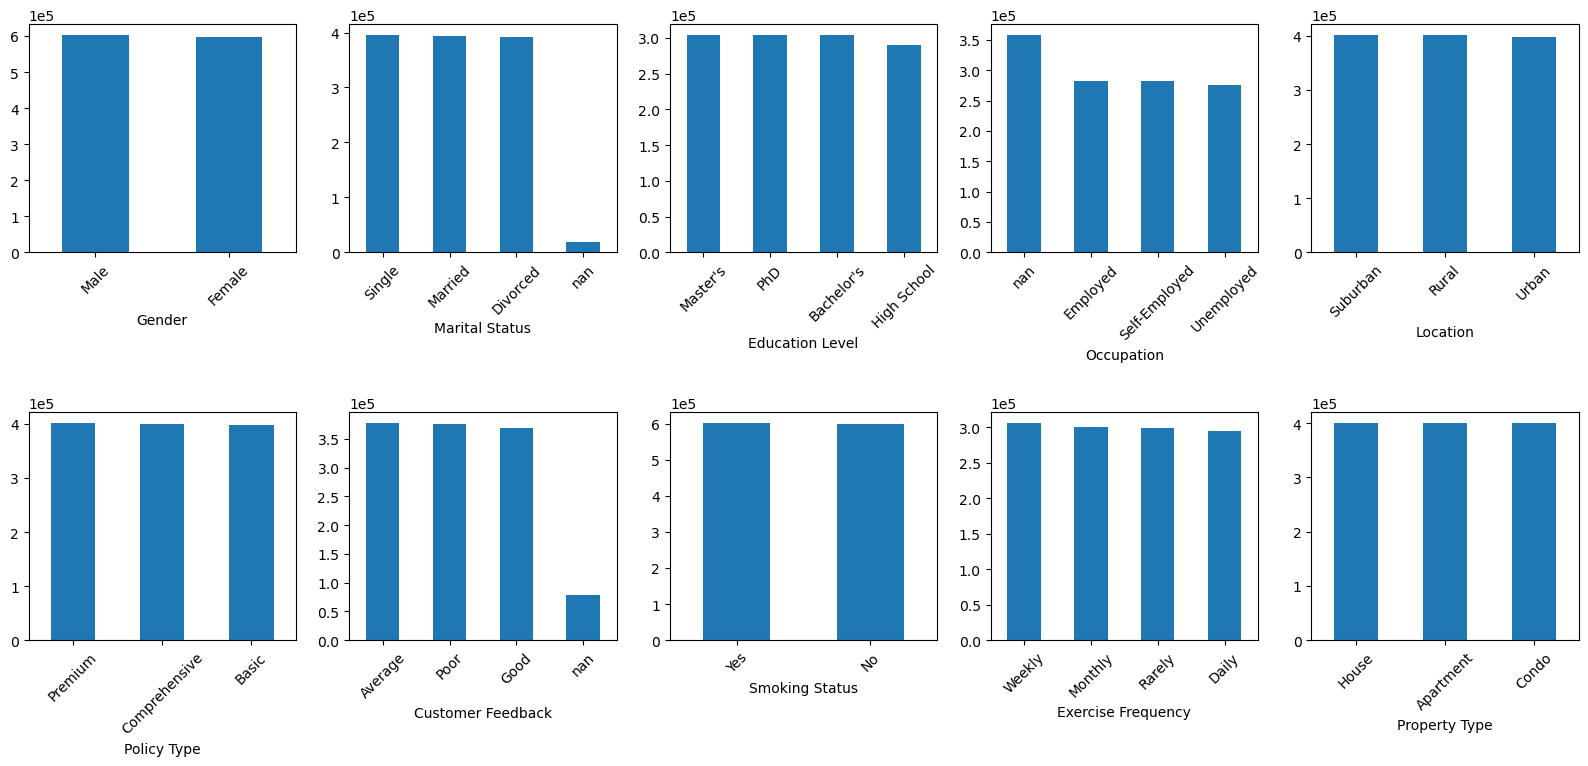

In [3]:
plt.figure(figsize=(20,8))
cat_cols = ['Gender','Marital Status', 'Education Level', 'Occupation','Location','Policy Type',
                'Customer Feedback', 'Smoking Status', 'Exercise Frequency','Property Type']
for i,c in enumerate(cat_cols):
    plt.subplot(2,5,i+1)
    df[c].value_counts(dropna=False).plot(kind='bar')
    plt.ticklabel_format(axis='y',scilimits=(0,0))
    plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.7)

## Plotting continuous features
Policy Start Date was converted to seconds since POSIX epoch so that it could be treated as a float. 
Age, Credit Score, Insurance Duration, Number of Dependents, Vehicle Age and Policy Start Date were all approximately uniformly distributed.
Annual Income, Premium Amount and Previous Claims were right-skewed
Health score was slightly right-skewed

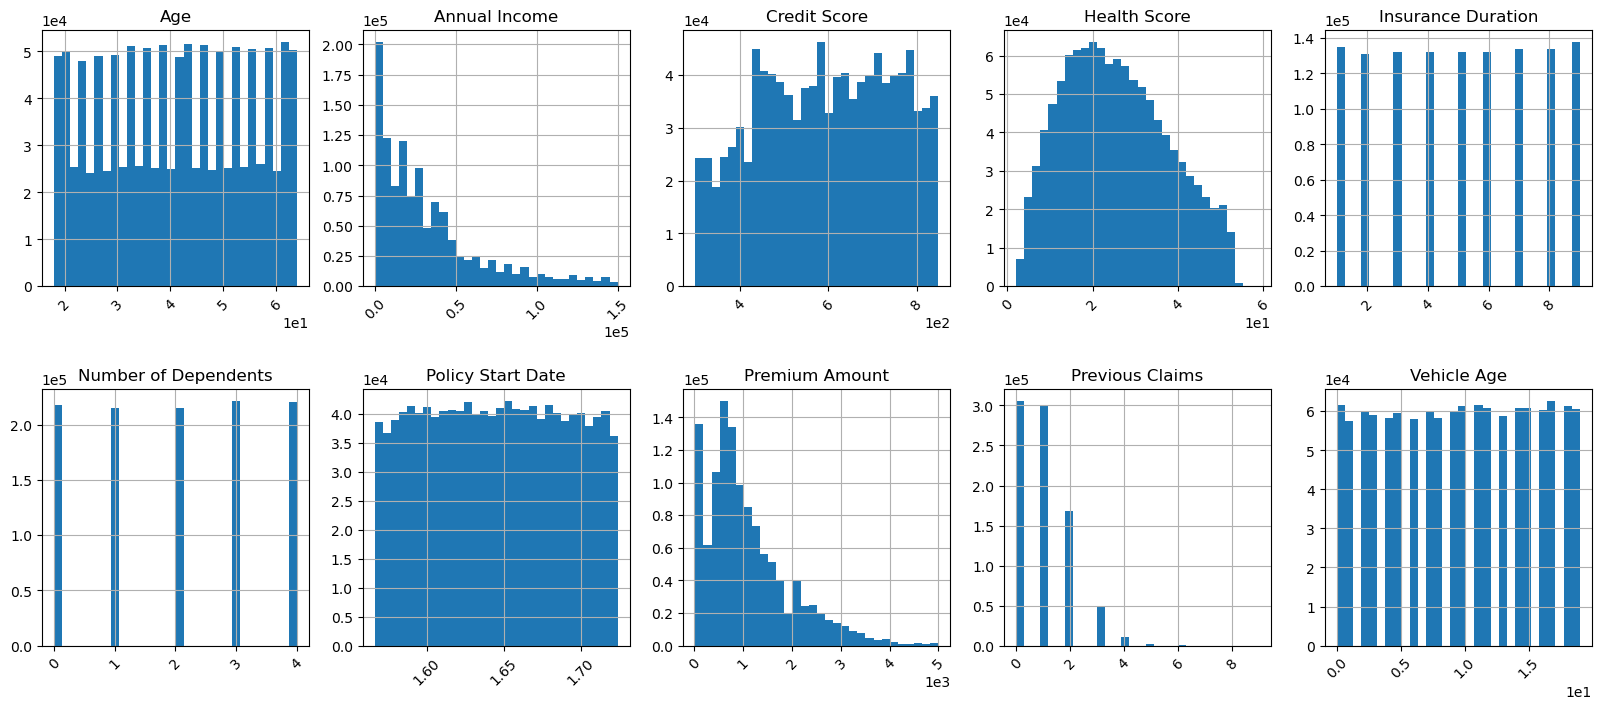

In [4]:
cont_cols = ['Age', 'Annual Income', 'Credit Score', 'Health Score',
       'Insurance Duration', 'Number of Dependents', 'Policy Start Date',
       'Premium Amount', 'Previous Claims', 'Vehicle Age']
df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date']).apply(lambda x: x.timestamp())
plt.figure(figsize=(20,8))
for i,c in enumerate(cont_cols):
    plt.subplot(2,5,i+1)
    if c == 'Policy Start Date':
        pd.to_datetime(df[c]).apply(lambda x: x.timestamp()).hist(bins=30)
    else:
        df[c].hist(bins=30)
    plt.title(c)
    plt.ticklabel_format(axis='both',scilimits=(0,0))
    plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.4)

## Missing values
Certain features have missing values, with Occupation and Previous Claims having 30% missing

In [5]:
pd.DataFrame(df.isna().mean().sort_values().apply(lambda x: '%.1f'%(100*x)),columns=['% missing'])

,% missing
Policy Type,0.0
Exercise Frequency,0.0
Smoking Status,0.0
Policy Start Date,0.0
Property Type,0.0
Location,0.0
Premium Amount,0.0
Education Level,0.0
Gender,0.0
Insurance Duration,0.0


## Preprocessing function
Based on the previous observations, a function to preprocess the data was prepared.

Previous claims had many missing values and few values greater than 2- to include these it was converted to categorical

***UPDATE FOR CATEGORICAL FEATURES***: 

Instead of one-hot encoding, this notebook retains the features as categorical dtype for use in the HistGradientBoosting function (which supports native categorical features). This reduces the number of features needed and avoids the creation of sparse features. Many of the categorical features are not ordinal, and so cannot be represented as continuous data.

In [6]:
def preprocess_data(df):
    cat_cols = ['Gender','Marital Status', 'Education Level', 'Occupation','Location','Policy Type',
                'Customer Feedback', 'Smoking Status', 'Exercise Frequency','Property Type']
    # convert text features to categorical dtype after replacing missing values with new class
    for c in cat_cols:
        df[c] = df[c].fillna('missing').astype('category')
    
    #df['Previous Claims'] = df['Previous Claims'].clip(0,2).replace({np.nan:'missing',0:'none',1:'one',2:'two_or_more'}).astype('category')

    cat_cols.append('Previous Claims')

    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date']).apply(lambda x: x.timestamp())

    cont_cols = np.setdiff1d(df.columns,cat_cols)
    # impute missing values for remaining continuous features
    df[cont_cols] = df[cont_cols].fillna(df[cont_cols].median())

    return df

In [7]:
df = preprocess_data(df)
df_test = preprocess_data(df_test)

## Target definition
Premium Amount is the prediction target. The performance metric is the root mean square log error (RMSLE).
It differs from root mean square error (RMSE)in that RMSLE will penalize under-estimation more than over-estimation. To get good performance, we want to optimize our models for the squared log loss rather than the squared loss. However, squared loss is more commonly available as a loss in different ML algorithms. We can therefore take the log of the target in advance, so that we are effectively optimizing for RMSLE

In [8]:
target = df['Premium Amount']
# competition metric is root mean square log loss -> log-transform target first so that can use common mean-squares losses to optimize for the root mean square log loss
# will convert back predictions later
transformed_target = np.log1p(target)
X = df.drop(columns='Premium Amount')
Y = transformed_target = np.log1p(target)
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.9)

## Model fitting
Optimization using grid search and experiments with feature subsets were conducted. Minimal improvement was observed, and the biggest difference was between algorithms.

In [27]:
reg = HistGradientBoostingRegressor(
    categorical_features='from_dtype',
    learning_rate=0.02,
    max_features=0.1,
    min_samples_leaf=1,
    max_iter=1000,
    max_leaf_nodes=500,
    early_stopping=False
)
print('%.4f'%np.mean(
    cross_val_score(reg,X,Y,scoring='neg_root_mean_squared_error',cv=5)
))

-1.0545


In [28]:
reg.fit(xtrain,ytrain)
print('train:',root_mean_squared_error(ytrain,reg.predict(xtrain)))
print('test:',root_mean_squared_error(ytest,reg.predict(xtest)))
importance = permutation_importance(reg,xtest,ytest,scoring='neg_mean_squared_error',n_jobs=-1)
importance.pop('importances')
importance = pd.DataFrame().from_dict(importance)
importance.index = xtrain.columns

train: 1.0045035887504163
test: 1.0528759601957063


<Axes: >

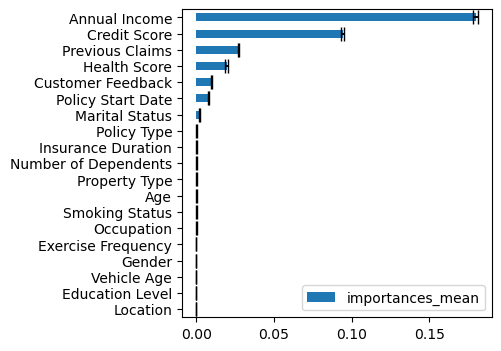

In [29]:
importance.sort_values(by='importances_mean').plot(kind='barh',xerr='importances_std',capsize=5,figsize=(4,4))

In [13]:
sel_cols = importance['importances_mean'].sort_values().tail(7).index

In [39]:
reg = HistGradientBoostingRegressor(
    categorical_features='from_dtype',
    max_features=0.8,
    max_iter=100,
    max_leaf_nodes=200,
)
print('%.4f'%np.mean(
    cross_val_score(reg,X,Y,scoring='neg_root_mean_squared_error',cv=5)
))
reg.fit(X,Y)
print('Train:',root_mean_squared_error(Y,reg.predict(X)))

-1.0481
Train: 1.0335606261409733


In [35]:
reg = HistGradientBoostingRegressor(
    categorical_features='from_dtype',
    max_features=0.8,
    max_iter=100,
    max_leaf_nodes=200,
)
print('%.4f'%np.mean(
    cross_val_score(reg,X[sel_cols],Y,scoring='neg_root_mean_squared_error',cv=5)
))
reg.fit(X[sel_cols],Y)
print('Train:',root_mean_squared_error(Y,reg.predict(X[sel_cols])))

-1.0476
Train: 1.0379285427218246


In [36]:
reg = HistGradientBoostingRegressor(
    categorical_features='from_dtype',
    learning_rate=0.01,
    max_iter =500,
    max_features = .8,
    max_leaf_nodes=500,
    min_samples_leaf=100
)
print('%.4f'%np.mean(
    cross_val_score(reg,X[sel_cols],Y,scoring='neg_root_mean_squared_error',cv=5)
))
reg.fit(X[sel_cols],Y)

print('Train:',root_mean_squared_error(Y,reg.predict(X[sel_cols])))

-1.0483
Train: 1.0338776609514089


In [37]:
reg = HistGradientBoostingRegressor(
    categorical_features='from_dtype',
    learning_rate=0.01,
    max_iter =500,
    max_features = .8,
    max_leaf_nodes=100,
)
print('%.4f'%np.mean(
    cross_val_score(reg,X[sel_cols],Y,scoring='neg_root_mean_squared_error',cv=5)
))
reg.fit(X[sel_cols],Y)

print('Train:',root_mean_squared_error(Y,reg.predict(X[sel_cols])))

-1.0471
Train: 1.0436266657245872


In [38]:
reg = XGB.XGBRegressor(
    enable_categorical=True
)
print('%.4f'%np.mean(
    cross_val_score(reg,X,Y,scoring='neg_root_mean_squared_error',cv=5)
))

-1.0486


In [14]:
pipe = StackingRegressor([
    ('HistGBR',HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1,max_features=0.8,max_iter=500)),
    ('XGB',XGB.XGBRegressor(enable_categorical=True))],verbose=3,cv=3,n_jobs=-1)
print('%.4f'%np.mean(cross_val_score(pipe,X,Y,scoring='neg_root_mean_squared_error',cv=5)))

KeyboardInterrupt: 

In [46]:
pipe.fit(X,Y)
pred = np.expm1(pipe.predict(df_test))
pd.DataFrame().from_dict({'id':df_test.index,'Premium Amount':pred}).to_csv('my_sample_submission.csv',index=False)

In [15]:
reg = HistGradientBoostingRegressor(
    categorical_features='from_dtype',
)
print('%.4f'%np.mean(
    cross_val_score(reg,X[sel_cols],Y,scoring='neg_root_mean_squared_error',cv=5)
))
reg.fit(X[sel_cols],Y)
print('Train:',root_mean_squared_error(Y,reg.predict(X[sel_cols])))

-1.0471
Train: 1.0458085127414236


In [16]:
pred = np.expm1(reg.predict(df_test[sel_cols]))
pd.DataFrame().from_dict({'id':df_test[sel_cols].index,'Premium Amount':pred}).to_csv('my_sample_submission.csv',index=False)

In [52]:
reg = HistGradientBoostingRegressor(
    categorical_features='from_dtype',
    learning_rate=0.1,
    max_iter =500,
    max_features = .33,
    max_leaf_nodes=200,
    min_samples_leaf=200
)
print('%.4f'%np.mean(
    cross_val_score(reg,X[sel_cols],Y,scoring='neg_root_mean_squared_error',cv=5)
))
reg.fit(X[sel_cols],Y)
print('Train:',root_mean_squared_error(Y,reg.predict(X[sel_cols])))


-1.0479
Train: 1.039945355623315


In [53]:
reg.predict(X)

array([6.86047789, 6.6113936 , 6.71644057, ..., 5.20837087, 6.65805099,
       5.8920533 ])

In [17]:
reg = HistGradientBoostingRegressor(categorical_features='from_dtype',
    learning_rate=0.1,
    max_iter =500,
    max_features = .33,
    max_leaf_nodes=200,
    min_samples_leaf=200
)
print('%.4f'%np.mean(
    cross_val_score(reg,X[sel_cols],Y,scoring='neg_root_mean_squared_error',cv=5)
))
reg.fit(X[sel_cols],Y)
print('Train:',root_mean_squared_error(Y,reg.predict(X[sel_cols])))

-1.0476
Train: 1.0418374903816725


In [18]:
pred = np.expm1(reg.predict(df_test[sel_cols]))
pd.DataFrame().from_dict({'id':df_test[sel_cols].index,'Premium Amount':pred}).to_csv('my_sample_submission.csv',index=False)